In [2]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

import warnings
warnings.filterwarnings('ignore')

## 2| Exploring the dataset <a class="anchor" id="exp"></a>

<Axes: >

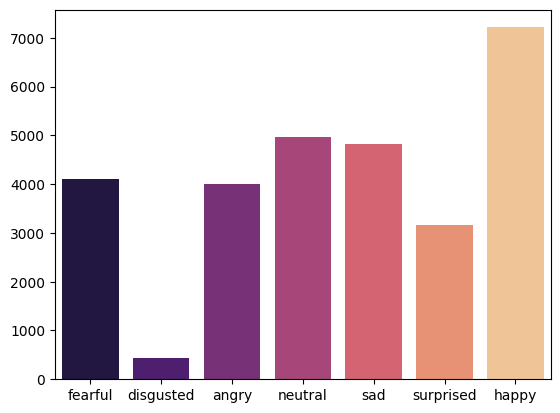

In [2]:
train_dir = '/kaggle/input/emotion-detection-fer/train'
emotions = os.listdir(train_dir)

train_counts = []

for emotion in emotions:
    folder = os.path.join(train_dir, emotion)
    train_counts.append(len(os.listdir(folder)))
    
sns.barplot(x=emotions, y=train_counts, palette='magma')

<Axes: >

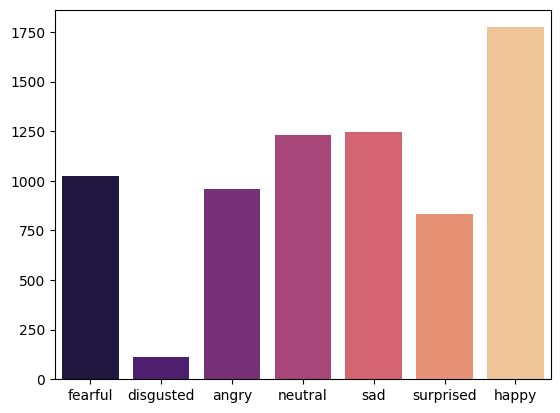

In [3]:
test_dir = '/kaggle/input/emotion-detection-fer/test'

test_counts = []

for emotion in emotions:
    folder = os.path.join(test_dir, emotion)
    test_counts.append(len(os.listdir(folder)))
    
sns.barplot(x=emotions, y=test_counts, palette='magma')

Seems like we'll have to adjust the class weights to deal with the data imbalance.

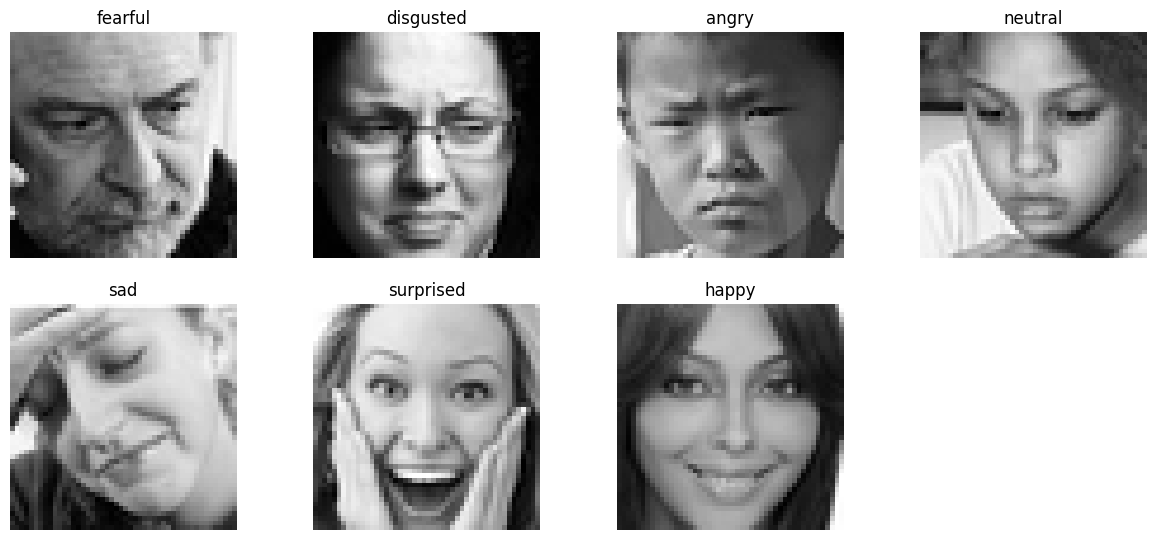

In [4]:
plt.figure(figsize=(15,10))

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[42])
    img = plt.imread(img_path)
    plt.subplot(3, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

## 3| Image data generators and augmentation <a class="anchor" id="gen"></a>

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    rescale=1/255
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## 4| Calculating class weights <a class="anchor" id="wghts"></a>

In [6]:
classes = np.array(train_generator.classes)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)

class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 1.0266046844269623,
 1: 9.406618610747051,
 2: 1.0010460615781582,
 3: 0.5684387684387684,
 4: 0.8260394187886635,
 5: 0.8491274770777877,
 6: 1.293372978330405}

## 5| Transfer learning model design <a class="anchor" id="des"></a>

In [12]:
input_shape = (224, 224, 3)  

base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=input_shape)

model = Sequential([
    base_model,
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.1),
    Dense(256, activation='relu'),
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(7, activation='softmax')
])

optimizer = Adamax(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ ?                      │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 23,519,360 (89.72 MB)

 Non-trainable params: 45,440 (177.50 KB)

## 6| Model training <a class="anchor" id="train"></a>

In [13]:
train_history = model.fit(
    train_generator,
    steps_per_epoch=200,
    epochs=50,
    validation_data=test_generator,
    validation_steps=100,
    class_weight=class_weights_dict
)

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 126s 379ms/step - accuracy: 0.1856 - loss: 1.9206 - val_accuracy: 0.2681 - val_loss: 1.8368
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 92s 460ms/step - accuracy: 0.2492 - loss: 1.8775 - val_accuracy: 0.2975 - val_loss: 1.7816
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 70s 349ms/step - accuracy: 0.2779 - loss: 1.7872 - val_accuracy: 0.3599 - val_loss: 1.7142
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 69s 345ms/step - accuracy: 0.3039 - loss: 1.7137 - val_accuracy: 0.4097 - val_loss: 1.5724
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 32s 161ms/step - accuracy: 0.3449 - loss: 1.6163 - val_accuracy: 0.4313 - val_loss: 1.4835
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 70s 340ms/step - accuracy: 0.3562 - loss: 1.5876 - val_accuracy: 0.4460 - val_loss: 1.4825
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 71s 354ms/step - accuracy: 0.4098 - loss: 1.5115 - val_accuracy: 0.4944 - val_loss: 1.3607
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 71s 355ms/step - accuracy: 0.4229 - loss: 

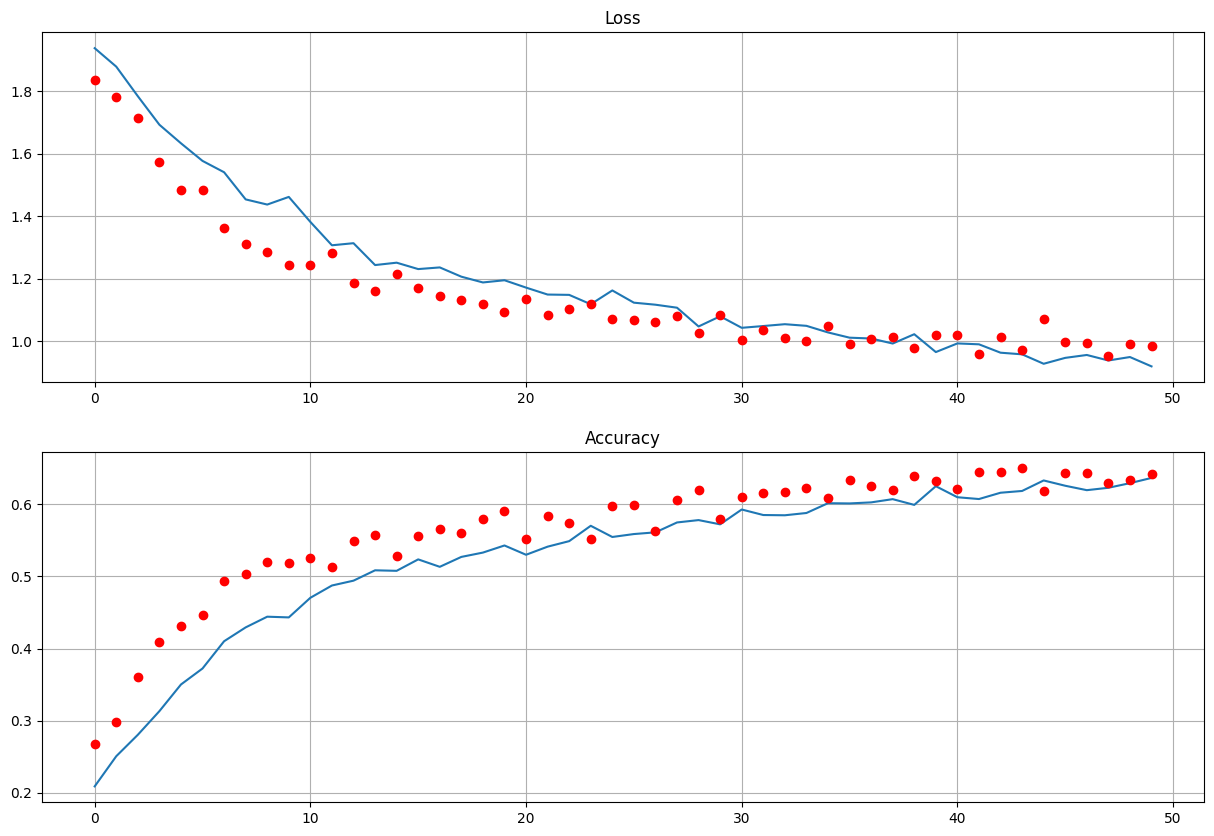

In [14]:
plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'], 'ro')
plt.title('Loss')
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'], 'ro')
plt.title('Accuracy')
plt.grid(True)

## 7| Model Evaluation <a class="anchor" id="eval"></a>

In [15]:
# redefining the test generator so it doesnt shuffle
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

true_labels = test_generator.classes
preds = model.predict(test_generator, steps=len(test_generator))
pred_labels = np.argmax(preds, axis=1)
classes=list(test_generator.class_indices.keys())

Found 7178 images belonging to 7 classes.
225/225 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step


In [16]:
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.56      0.54      0.55       958
           1       0.55      0.68      0.60       111
           2       0.49      0.36      0.42      1024
           3       0.89      0.84      0.87      1774
           4       0.60      0.63      0.61      1233
           5       0.50      0.56      0.53      1247
           6       0.66      0.82      0.73       831

    accuracy                           0.64      7178
   macro avg       0.61      0.63      0.62      7178
weighted avg       0.64      0.64      0.64      7178



Text(0.5, 1.0, 'Confusion Matrix')

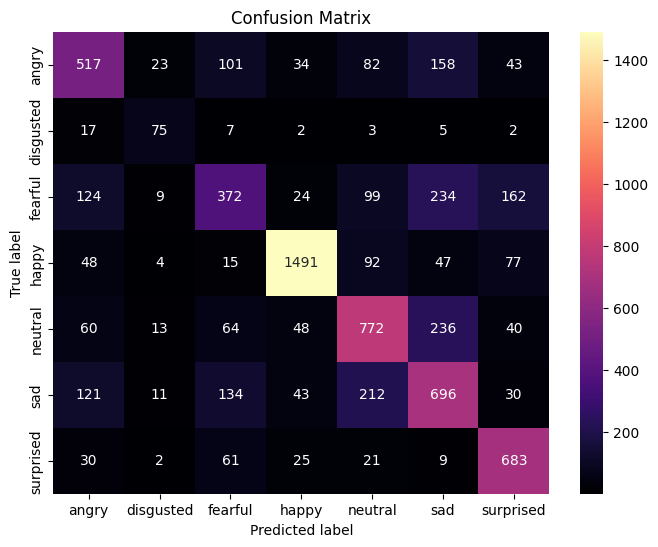

In [17]:
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="magma", xticklabels=classes, yticklabels=classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')

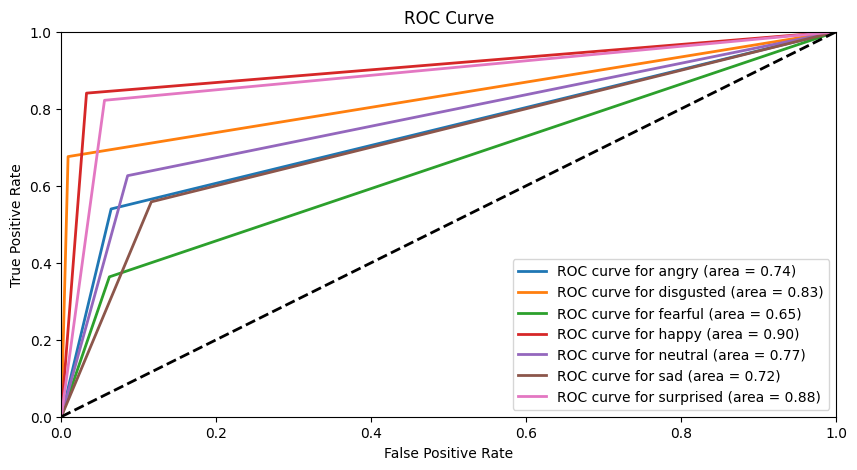

In [18]:
y_encoded = pd.get_dummies(true_labels).astype(int).values
preds_encoded = pd.get_dummies(pred_labels).astype(int).values

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_encoded[:,i], preds_encoded[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10,5))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"ROC curve for {classes[i]} (area = {roc_auc[i]:0.2f})")
    
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

In [ ]:
model.save('EmotionDetector.h5')

## Conclusion <a class="anchor" id="con"></a>

The results are a little less that I hoped for, but that's okay. The main goal of this notebook was to test out transfer learning and it does indeed help a whole lot but picking the right network takes some trial and error. Overall, this project had been a fun experience.

If you have any questions or recommendations feel free to comment, and I hope you found this notebook helpful.